In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import warnings

In [9]:
df = pd.read_csv("synthetic_load_with_missing.csv")

In [10]:
df = df.rename(columns={'Unnamed: 0': 'Datetime'})

In [11]:
df.head()

,Datetime,hour,dayofweek,dayofyear,temp,solar,wind,load
0,2023-01-01 00:00:00,0,6,1,10.668848,-0.076225,1.738539,17.533565
1,2023-01-01 01:00:00,1,6,1,11.327964,0.532552,2.098603,NaN
2,2023-01-01 02:00:00,2,6,1,13.319822,0.521505,1.151178,10.328752
3,2023-01-01 03:00:00,3,6,1,15.230697,0.928072,2.683639,13.847641
4,2023-01-01 04:00:00,4,6,1,14.268107,1.453223,0.438029,11.776826


In [12]:
# Convert timestamp
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
print("\n=== DATA HEAD ===")
print(df.head())
print("\n=== MISSING VALUES ===")
print(df.isna().sum())


=== DATA HEAD ===
                     hour  dayofweek  dayofyear       temp     solar  \
Datetime                                                               
2023-01-01 00:00:00     0          6          1  10.668848 -0.076225   
2023-01-01 01:00:00     1          6          1  11.327964  0.532552   
2023-01-01 02:00:00     2          6          1  13.319822  0.521505   
2023-01-01 03:00:00     3          6          1  15.230697  0.928072   
2023-01-01 04:00:00     4          6          1  14.268107  1.453223   

                         wind       load  
Datetime                                  
2023-01-01 00:00:00  1.738539  17.533565  
2023-01-01 01:00:00  2.098603        NaN  
2023-01-01 02:00:00  1.151178  10.328752  
2023-01-01 03:00:00  2.683639  13.847641  
2023-01-01 04:00:00  0.438029  11.776826  

=== MISSING VALUES ===
hour           0
dayofweek      0
dayofyear      0
temp           0
solar          0
wind           0
load         876
dtype: int64


In [13]:
df.columns

Index(['hour', 'dayofweek', 'dayofyear', 'temp', 'solar', 'wind', 'load'], dtype='object')

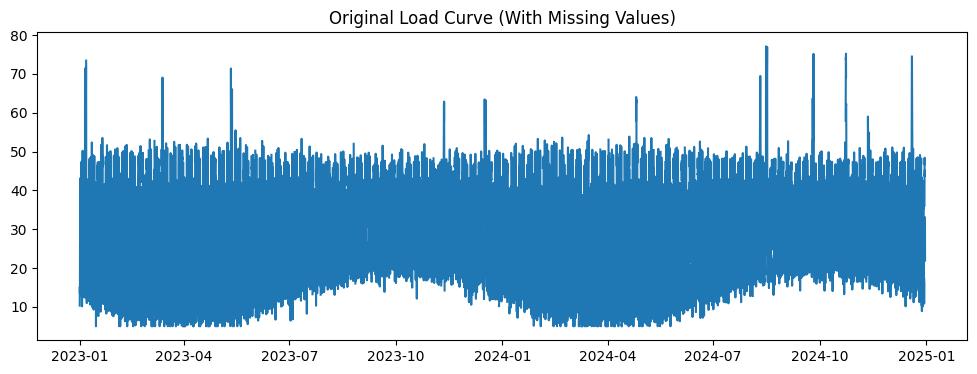

In [14]:
plt.figure(figsize=(12,4))
plt.plot(df['load'])
plt.title("Original Load Curve (With Missing Values)")
plt.show()

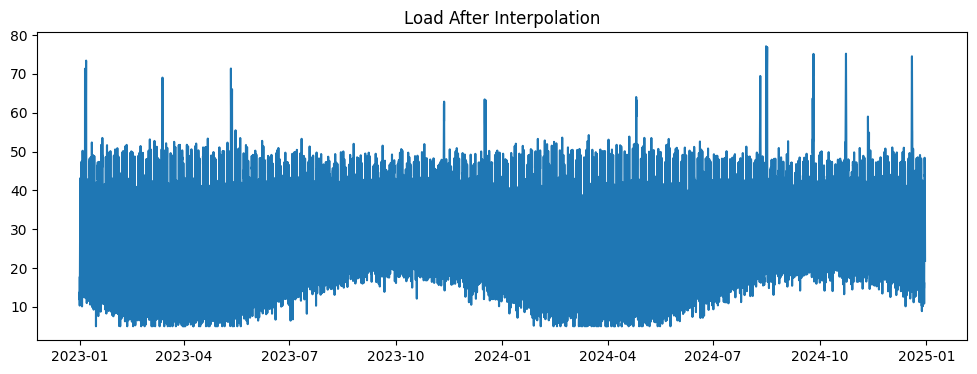

In [15]:
# Time-based interpolation (best for load curves)
df['load'] = df['load'].interpolate(method='time')
plt.figure(figsize=(12,4))
plt.plot(df['load'])
plt.title("Load After Interpolation")
plt.show()

In [16]:
# 2. SPLIT TRAIN AND TEST (LAST 7 DAYS FOR TEST)
# ======================================
# Assuming your data is hourly; if different, adjust freq
test_days = 7
test = df['load'][-test_days*24:]   # last 7 days
train = df['load'][:-test_days*24]  # everything before last 7 days

print(f"\nTrain size: {len(train)}   Test size: {len(test)}")


Train size: 17352   Test size: 168


In [1]:
!pip install cmdstanpy

In [2]:
import cmdstanpy
cmdstanpy.install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpcp95a71b
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
Installed cmdstan-2.37.0
Test model compilation


True

In [4]:
!conda install -c conda-forge prophet

/bin/bash: line 1: conda: command not found


In [5]:
%pip uninstall prophet fbprophet -y
%pip install prophet
%pip install cmdstanpy

Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)


In [6]:
from prophet import Prophet
model = Prophet()
print("Prophet is working! 🎉")

Prophet is working! 🎉


In [17]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime index
df = df.copy()
df['ds'] = pd.to_datetime(df.index)

# Target variable
df['y'] = df['load']

# Select regressors
regressors = ['hour', 'dayofweek', 'dayofyear', 'temp', 'solar', 'wind']

# Train-Test split for last 7 days
test_hours = test_days * 24
train_df = df.iloc[:-test_hours]
test_df = df.iloc[-test_hours:]

train_p = train_df[['ds', 'y'] + regressors]
test_p = test_df[['ds', 'y'] + regressors]

In [18]:
model = Prophet()
for r in regressors:
    model.add_regressor(r)

model.fit(train_p)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [19]:
future = model.make_future_dataframe(periods=test_hours, freq='H')

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [20]:
future['hour'] = future['ds'].dt.hour
future['dayofweek'] = future['ds'].dt.dayofweek
future['dayofyear'] = future['ds'].dt.dayofyear
future['temp'] = df['temp'].iloc[-len(future):].values
future['solar'] = df['solar'].iloc[-len(future):].values
future['wind'] = df['wind'].iloc[-len(future):].values

In [21]:
forecast = model.predict(future)

In [22]:
pred = forecast.set_index('ds')['yhat'].loc[test_p['ds']]

In [23]:
mae = mean_absolute_error(test_p['y'], pred)
rmse = np.sqrt(mean_squared_error(test_p['y'], pred))
mape = np.mean(np.abs((test_p['y'] - pred) / test_p['y'])) * 100

print("\n=== PROPHET PERFORMANCE (Last 7 Days) ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")


=== PROPHET PERFORMANCE (Last 7 Days) ===
MAE  : 1.9108
RMSE : 2.3835
MAPE : 8.23%


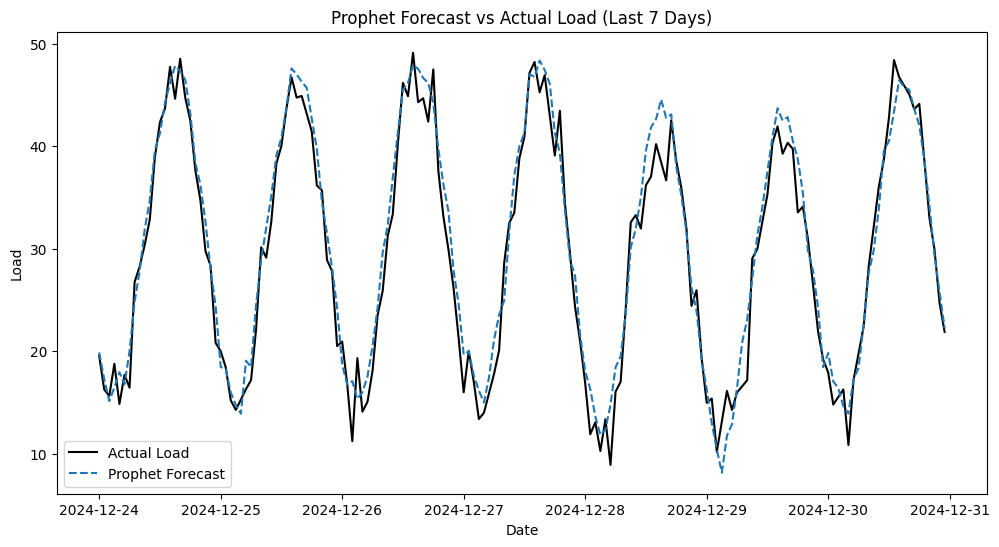

In [25]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Load', color='black')
plt.plot(pred.index, pred.values, label='Prophet Forecast', linestyle='dashed')
plt.title("Prophet Forecast vs Actual Load (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Load")
plt.legend()
plt.show()

In [26]:
import joblib

# ===== SAVE MODEL (.pkl) =====
model_path = "prophet.pkl"
joblib.dump(model, model_path)
print(f"Model saved successfully as {model_path}")

Model saved successfully as prophet.pkl


In [37]:
results_df = pd.DataFrame({
    'DateTime': test_p['ds'].values,
    'actual': test_p['y'].values,
    'predicted': pred.values
})

csv_path = "prophet.csv"
results_df.to_csv(csv_path, index=False)

print(f"Forecast results saved successfully as {csv_path}")

Forecast results saved successfully as prophet.csv


In [38]:
a=pd.read_csv('/content/prophet.csv')

In [39]:
a.tail()

,DateTime,actual,predicted
163,2024-12-30 19:00:00,38.567452,38.638966
164,2024-12-30 20:00:00,33.009601,34.167256
165,2024-12-30 21:00:00,29.930362,29.347589
166,2024-12-30 22:00:00,24.689380,25.760727
167,2024-12-30 23:00:00,21.885866,22.244347


In [ ]:
from prophet.serialize import model_to_json

In [36]:
from prophet.serialize import model_to_json

with open("prophet_model.json", "w") as f:
    f.write(model_to_json(model))